In [ ]:

import chess
import chess.pgn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import math

# Configuration
CONFIG = {
    "pgn_file": "filtered_games_2000plus.pgn",
    "batch_size": 2048*2,
    "lr": 0.001,
    "epochs": 20,
    "num_res_blocks": 4,   # Depth of the ResNet
    "num_channels": 256,    # Width of the network
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Running on: {CONFIG['device']}")

Running on: cuda


In [ ]:

class AlphaZeroChessEncoding:
    """
    Encodes chess moves into the 8x8x73 (4672) integer action space.
    """
    def __init__(self):
        self.queen_dirs = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
        self.knight_moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
        self.under_promotions = [chess.KNIGHT, chess.BISHOP, chess.ROOK]
        self.under_promo_dirs = [0, -1, 1] 

    def encode(self, move: chess.Move, board: chess.Board) -> int:
        from_sq = move.from_square
        to_sq = move.to_square
        
        # Orient based on color (Always view board from "my" perspective)
        if board.turn == chess.BLACK:
            from_sq = 63 - from_sq
            to_sq = 63 - to_sq

        delta_rank = chess.square_rank(to_sq) - chess.square_rank(from_sq)
        delta_file = chess.square_file(to_sq) - chess.square_file(from_sq)

        plane_idx = -1
        is_knight = board.piece_type_at(move.from_square) == chess.KNIGHT
        is_promo = bool(move.promotion)

        # 1. Promotions 
        if is_promo and move.promotion in self.under_promotions:
            promo_idx = self.under_promotions.index(move.promotion)
            dir_idx = self.under_promo_dirs.index(delta_file)
            plane_idx = 64 + (dir_idx * 3) + promo_idx

        # 2. Knight Moves
        elif is_knight:
            try:
                k_idx = self.knight_moves.index((delta_rank, delta_file))
                plane_idx = 56 + k_idx
            except ValueError: return None 

        # 3. Queen-like moves 
        else:
            dist = max(abs(delta_rank), abs(delta_file))
            if dist == 0: return None
            
            d_rank = delta_rank // dist
            d_file = delta_file // dist
            
            try:
                dir_idx = self.queen_dirs.index((d_rank, d_file))
                plane_idx = (dir_idx * 7) + (dist - 1)
            except ValueError: return None 

        return (from_sq * 73) + plane_idx


encoder = AlphaZeroChessEncoding()

In [ ]:

def board_to_tensor(board):
    """
    Converts a python-chess board into a 12x8x8 Tensor.
    Layers: P, N, B, R, Q, K (White) then P, N, B, R, Q, K (Black)
    """
    piece_map = {
        chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
        chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5
    }
    
    matrix = np.zeros((12, 8, 8), dtype=np.float32)
    
    for square, piece in board.piece_map().items():
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        
        layer = piece_map[piece.piece_type]
        
        # If black piece, offset layer by 6
        if piece.color == chess.BLACK:
            layer += 6

        # FLIP BOARD if Black to play
        if board.turn == chess.BLACK:
            rank = 7 - rank
            file = 7 - file 
            
            if layer < 6: layer += 6
            else: layer -= 6

        sign = 0
        if piece.color == chess.BLACK:
            sign = -1
        else:
            sign = 1

        matrix[layer, rank, file] = 1.0 * sign

    return torch.tensor(matrix)

In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, num_channels, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.dropout = nn.Dropout(dropout) 
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out) 
        out = self.bn2(self.conv2(out))
        out += residual 
        out = F.relu(out)
        return out

class ChessResNet(nn.Module):
    def __init__(self, num_res_blocks=CONFIG["num_res_blocks"], num_channels=CONFIG["num_channels"], num_actions=4672, dropout=0.1):
        super(ChessResNet, self).__init__()
    
        self.start_block = nn.Sequential(
            nn.Conv2d(12, num_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_channels),
            nn.ReLU()
        )
        
        # Tower of Residual Blocks
        self.backbone = nn.ModuleList(
            [ResidualBlock(num_channels, dropout=dropout) for _ in range(num_res_blocks)]
        )
        
        # Policy Head (Predicts Move)
        self.policy_head = nn.Sequential(
            nn.Conv2d(num_channels, 2, kernel_size=1), 
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(dropout), 
            nn.Linear(2 * 8 * 8, num_actions) 
        )
        
        # Value Head (Predicts Win/Loss) 
        self.value_head = nn.Sequential(
            nn.Conv2d(num_channels, 1, kernel_size=1), 
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1 * 8 * 8, 64),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(64, 1),
            nn.Tanh() 
        )

    def forward(self, x):
        out = self.start_block(x)
        
        for block in self.backbone:
            out = block(out)
            
        policy = self.policy_head(out)
        value = self.value_head(out)
        
        return policy, value

In [ ]:
class ChessPGNDataset(Dataset):
    def __init__(self, pgn_file, max_games=None):
        self.data = []
        self.load_data(pgn_file, max_games)

    def load_data(self, pgn_file, max_games):
        print("Parsing PGN data...")
        with open(pgn_file, 'r') as f:
            count = 0
            while True:
                game = chess.pgn.read_game(f)
                if game is None: break

                result_map = {'1-0': 1.0, '0-1': -1.0, '1/2-1/2': 0.0}
                if game.headers['Result'] not in result_map: continue
                game_result = result_map[game.headers['Result']]
                
                board = game.board()
                
                for move in game.mainline_moves():
                    # 1. Store State
                    state_tensor = board_to_tensor(board)
                    
                    # 2. Store Action (Target)
                    action_idx = encoder.encode(move, board)
                    
                    # 3. Generate Legal Move Mask 
                    legal_mask = np.zeros(4672, dtype=np.float32)
                    for legal_move in board.legal_moves:
                        idx = encoder.encode(legal_move, board)
                        if idx is not None:
                            legal_mask[idx] = 1.0

                    if action_idx is None:
                        board.push(move)
                        continue
                        
                    turn_multiplier = 1 if board.turn == chess.WHITE else -1
                    current_value_target = game_result * turn_multiplier
                    
                    self.data.append((state_tensor, action_idx, current_value_target, legal_mask))
                    
                    board.push(move)
                
                count += 1
                if max_games and count >= max_games: break
                if count % 100 == 0: print(f"Loaded {count} games...")
                
        print(f"Loaded {count} games...")
        print(f"Total positions loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        state, action, value, mask = self.data[idx]
        return state, action, torch.tensor(value, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)
    

dataset = ChessPGNDataset(CONFIG['pgn_file'], max_games=50000)
dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

Parsing PGN data...
Loaded 100 games...
Loaded 200 games...
Loaded 300 games...
Loaded 400 games...
Loaded 500 games...
Loaded 600 games...
Loaded 700 games...
Loaded 800 games...
Loaded 900 games...
Loaded 1000 games...
Loaded 1100 games...
Loaded 1200 games...
Loaded 1300 games...
Loaded 1400 games...
Loaded 1500 games...
Loaded 1600 games...
Loaded 1700 games...
Loaded 1800 games...
Loaded 1900 games...
Loaded 2000 games...
Loaded 2100 games...
Loaded 2200 games...
Loaded 2300 games...
Loaded 2400 games...
Loaded 2500 games...
Loaded 2600 games...
Loaded 2700 games...
Loaded 2800 games...
Loaded 2900 games...
Loaded 3000 games...
Loaded 3100 games...
Loaded 3200 games...
Loaded 3300 games...
Loaded 3400 games...
Loaded 3500 games...
Loaded 3600 games...
Loaded 3700 games...
Loaded 3800 games...
Loaded 3900 games...
Loaded 4000 games...
Loaded 4100 games...
Loaded 4200 games...
Loaded 4300 games...
Loaded 4400 games...
Loaded 4500 games...
Loaded 4600 games...
Loaded 4700 games...
Lo

: 

In [ ]:


import json
import time

# Configuration for Training Loop 
PATIENCE = 10          # Stop if no improvement for 10 epochs
checkpoint_dir = "checkpoints_new_31"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize Model & Optimizer
model = ChessResNet(num_res_blocks=CONFIG['num_res_blocks'], num_channels=CONFIG['num_channels']).to(CONFIG['device'])

optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)

policy_criterion = nn.CrossEntropyLoss()
value_criterion = nn.MSELoss()

# Tracking Variables 
history = {
    'epoch': [],
    'total_loss': [],
    'p_loss': [],
    'v_loss': []
}

best_loss = float('inf')
patience_counter = 0
epoch = 0

print("Starting Infinite Training (with Early Stopping)...")
start_time = time.time()

while True:
    epoch += 1
    model.train()
    
    running_loss = 0.0
    running_p_loss = 0.0
    running_v_loss = 0.0
    
    for batch_idx, (states, actions, values, masks) in enumerate(dataloader):
        states, actions, values, masks = states.to(CONFIG['device']), actions.to(CONFIG['device']), values.to(CONFIG['device']), masks.to(CONFIG['device'])
        
        optimizer.zero_grad()
        
        pred_policy, pred_value = model(states)
        
        huge_negative = torch.tensor(-1e9, device=CONFIG['device'], dtype=torch.float32)
        masked_policy_logits = pred_policy + ((1 - masks) * huge_negative)

        # Calculate Losses
        p_loss = policy_criterion(masked_policy_logits, actions)
        v_loss = value_criterion(pred_value.squeeze(), values)
        loss = p_loss + v_loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_p_loss += p_loss.item()
        running_v_loss += v_loss.item()
    
    # Calculate Averages for the Epoch 
    avg_loss = running_loss / len(dataloader)
    avg_p_loss = running_p_loss / len(dataloader)
    avg_v_loss = running_v_loss / len(dataloader)
    
    # Update History & Save to File 
    history['epoch'].append(epoch)
    history['total_loss'].append(avg_loss)
    history['p_loss'].append(avg_p_loss)
    history['v_loss'].append(avg_v_loss)
    
    # Save history to JSON 
    with open('training_history.json', 'w') as f:
        json.dump(history, f, indent=4)

    # Print Status 
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} (P: {avg_p_loss:.3f}, V: {avg_v_loss:.3f}) | Patience: {patience_counter}/{PATIENCE}")

    # Save Checkpoint for this specific epoch 
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"RTX3070_model_epoch_{epoch}.pth"))
    
    # Early Stopping Logic 
    if avg_loss < best_loss:
        print(f"   >>> New Best Model! (Previous: {best_loss:.4f} -> Current: {avg_loss:.4f})")
        best_loss = avg_loss
        patience_counter = 0
        # Save the best model specifically
        torch.save(model.state_dict(), "best_chess_resne_extended_RTX3070.pth")
    else:
        patience_counter += 1
        print(f"   --- No improvement. Patience counter: {patience_counter}")
        
    if patience_counter >= PATIENCE:
        print("\nEarly stopping triggered! Training finished.")
        break

print(f"Total training time: {(time.time() - start_time)/60:.1f} minutes")

No save found, starting from scratch.
Starting Infinite Training (with Early Stopping)...
Epoch 1 | Loss: 3.2774 (P: 2.418, V: 0.860) | Patience: 0/10
   >>> New Best Model! (Previous: inf -> Current: 3.2774)
Epoch 2 | Loss: 2.9501 (P: 2.117, V: 0.833) | Patience: 0/10
   >>> New Best Model! (Previous: 3.2774 -> Current: 2.9501)
Epoch 3 | Loss: 2.8492 (P: 2.032, V: 0.818) | Patience: 0/10
   >>> New Best Model! (Previous: 2.9501 -> Current: 2.8492)
Epoch 4 | Loss: 2.7779 (P: 1.980, V: 0.798) | Patience: 0/10
   >>> New Best Model! (Previous: 2.8492 -> Current: 2.7779)
Epoch 5 | Loss: 2.7197 (P: 1.946, V: 0.774) | Patience: 0/10
   >>> New Best Model! (Previous: 2.7779 -> Current: 2.7197)
Epoch 6 | Loss: 2.6695 (P: 1.922, V: 0.748) | Patience: 0/10
   >>> New Best Model! (Previous: 2.7197 -> Current: 2.6695)
Epoch 7 | Loss: 2.6277 (P: 1.904, V: 0.723) | Patience: 0/10
   >>> New Best Model! (Previous: 2.6695 -> Current: 2.6277)
Epoch 8 | Loss: 2.5935 (P: 1.890, V: 0.703) | Patience: 0/1

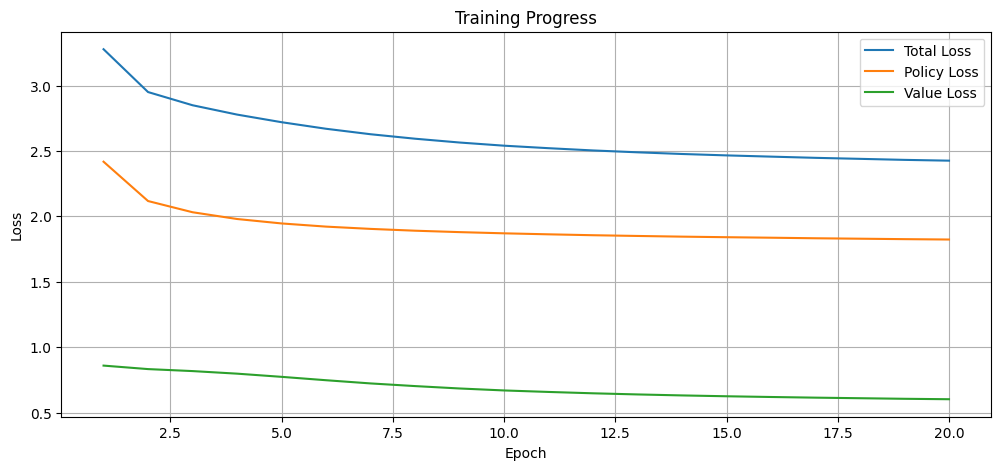

In [ ]:

import matplotlib.pyplot as plt

# Load the data
with open('training_history_RTX3070.json', 'r') as f:
    data = json.load(f)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(data['epoch'], data['total_loss'], label='Total Loss')
plt.plot(data['epoch'], data['p_loss'], label='Policy Loss')
plt.plot(data['epoch'], data['v_loss'], label='Value Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


class MCTS_Node:
    def __init__(self, parent=None, prior=0):
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value_sum = 0
        self.prior = prior  # Probability from the Neural Net

    def ucb_score(self, c_puct=1.0): 
            if self.visits == 0:
                return c_puct * self.prior * np.sqrt(self.parent.visits + 1e-8) 
            
            q_value = -self.value_sum / self.visits 
            
            u_value = c_puct * self.prior * (np.sqrt(self.parent.visits) / (1 + self.visits))
            
            return q_value + u_value

class MCTS:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def get_masked_policy(self, board, policy_logits):
        """
        Helper to mask illegal moves and re-normalize probabilities.
        """
        # 1. Get all legal moves and their encoded indices
        legal_moves = list(board.legal_moves)
        legal_indices = []
        valid_moves = []
        
        for move in legal_moves:
            idx = encoder.encode(move, board)
            if idx is not None:
                legal_indices.append(idx)
                valid_moves.append(move)
        
        # 2. Create a mask of -Infinity
        mask = np.full(4672, -1e9, dtype=np.float32)
        
        # 3. Fill in the values for legal moves
        logits_numpy = policy_logits.cpu().numpy().flatten()
        mask[legal_indices] = logits_numpy[legal_indices]
        
        # 4. Apply Softmax to the MASKED logits
        exp_logits = np.exp(mask - np.max(mask))
        probs = exp_logits / np.sum(exp_logits)
        
        return probs, valid_moves, legal_indices

    def search(self, board, num_simulations=800):
        root = MCTS_Node(prior=0)
        
        # 1. Evaluate root
        board_tensor = board_to_tensor(board).unsqueeze(0).to(self.device)
        with torch.no_grad():
            policy_logits, value = self.model(board_tensor)
            
        # Apply masking at Root
        root_probs, root_moves, root_indices = self.get_masked_policy(board, policy_logits)
        
        # Expand root with legal moves only
        for move, idx in zip(root_moves, root_indices):
            root.children[move] = MCTS_Node(parent=root, prior=root_probs[idx])
            
        root.visits = 1

        #  2. Run simulations
        for _ in range(num_simulations):
            node = root
            sim_board = board.copy()
            
            # A. Select (Traverse down until leaf or terminal)
            while len(node.children) > 0 and not sim_board.is_game_over():
                # Pick child with highest UCB
                move, node = max(node.children.items(), key=lambda item: item[1].ucb_score())
                sim_board.push(move)
            
            # B. Evaluate & Expand (If not terminal)
            leaf_value = 0
            if not sim_board.is_game_over():
                # Inference
                tensor = board_to_tensor(sim_board).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    p_logits, v = self.model(tensor)
                
                leaf_value = v.item()
                
                # Apply Masking for the leaf node
                leaf_probs, leaf_moves, leaf_indices = self.get_masked_policy(sim_board, p_logits)
                
                # Expand
                for move, idx in zip(leaf_moves, leaf_indices):
                    node.children[move] = MCTS_Node(parent=node, prior=leaf_probs[idx])
            
            else:
                # Terminal State Logic
                res = sim_board.result()
                if res == '1-0': leaf_value = 1
                elif res == '0-1': leaf_value = -1
                else: leaf_value = 0
                
                if sim_board.turn == chess.BLACK:
                    leaf_value = -leaf_value

            # C. Backpropagate values up the tree
            while node is not None:
                node.visits += 1
                node.value_sum += leaf_value
                # Flip value for the opponent at the parent node
                leaf_value = -leaf_value 
                node = node.parent
                
        return root

    def get_best_move(self, board, simulations=800):
        root = self.search(board, simulations)
        
        # If we have no children (checkmate/stalemate), return None
        if not root.children:
            return None
            
        # Select move with most visits
        best_move, best_node = max(root.children.items(), key=lambda item: item[1].visits)
        
        print(f"Visits: {best_node.visits} | Win Est: {best_node.value_sum/best_node.visits:.2f}")
        return best_move


In [ ]:

# Load Model 
loaded_model2 = ChessResNet(num_res_blocks=CONFIG['num_res_blocks'],
                           num_channels=CONFIG['num_channels']).to(CONFIG['device'])
loaded_model2.load_state_dict(torch.load("best_chess_resne_final.pth"))
loaded_model2.eval()

# Setup AI
mcts_engine_RTX = MCTS(loaded_model2, CONFIG['device'])
board = chess.Board()
board
print("Engine RTX Ready.")


Engine 1 Ready.
Engine RTX Ready.


Visits: 933 | Win Est: -0.70
AI RTX plays: b7c5
<LegalMoveGenerator at 0x16982bb9f40 (Ne7, Nh6, Nf6, Kd8, Kc8, Kb8, Kd6, Kb6, Rg7, Rg6, Rh5, Rf5, Rxg4, Ng6, Ne6, Nh5, Nh3, Nd3+, Ng2, Ne2+, exd4, bxc3, e4, b3)>


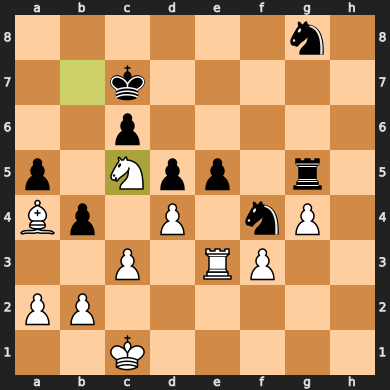

In [ ]:
best_move = mcts_engine_RTX.get_best_move(board, simulations=1600)
print(f"AI RTX plays: {best_move}")
board.push(best_move)
print(board.legal_moves)
board

<LegalMoveGenerator at 0x169f2444780 (Ne7, Nh6, Nf6, Kd8, Kc8, Kb8, Kd6, Kb6, Rg7, Rg6, Rh5, Rf5, Rxg4, Ng6, Ne6, Nh5, Nh3, Nd3+, Ng2, Ne2+, exd4, bxc3, e4, b3)>


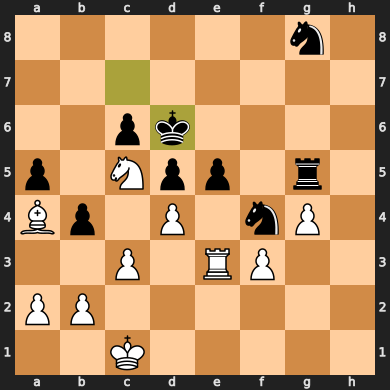

In [ ]:
print(board.legal_moves)

board.push_san('Kd6')
board

In [ ]:
import chess.pgn

game = chess.pgn.Game.from_board(board)

# Display game history for analysis
print(str(game))


[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. e4 d6 2. d4 Nf6 3. Nc3 g6 4. h4 h5 5. Bc4 Bd7 6. Nf3 Bg4 7. Qe2 c6 8. Bg5 Nfd7 9. O-O-O b5 10. Bb3 f6 11. Qe3 fxg5 12. Nxg5 d5 13. Rde1 b4 14. Na4 Nf6 15. f3 Bd7 16. e5 Ng8 17. e6 Bh6 18. exd7+ Nxd7 19. Qe6 Bxg5+ 20. hxg5 Qc8 21. Qxg6+ Kd8 22. Rxh5 Rxh5 23. Qxh5 Kc7 24. Qf7 Qf8 25. Qxf8 Rxf8 26. Re6 Rf5 27. g6 Nf8 28. Re1 Rg5 29. g4 a5 30. Re3 Nxg6 31. Nc5 Nf4 32. Ba4 Kd6 33. c3 e5 34. Nb7+ Kc7 35. Nc5 Kd6 36. Nb7+ Kc7 37. Nc5 Kd6 *
